# DESARROLLO PROYECTO TFM

En esta página se desarrollará el código python con el que se ha desarrollado el proyecto del TFM. Se construirá el modelo de regresión logística más parsimonioso y mejor ajustado para predecir si un paciente puede sufrir una cardiopatía coronaria en 10 años a partir de ciertas variables predictoras. 




## Importación de librerías

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

##Importanción del conjunto de datos

In [2]:
# read the data
df = pd.read_csv('train.csv')
df = df.drop(['education','id'], axis=1)
df.head()

,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,36,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


Dimensiones del dataset y tipos de variables que contiene

In [3]:
# shape and data types of the data
print(df.shape)
print(df.dtypes)

(3390, 15)
age                  int64
sex                 object
is_smoking          object
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object


VARIABLES NUMÉRICAS

Variables numéricas que componen el dataset

In [4]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['age' 'cigsPerDay' 'BPMeds' 'prevalentStroke' 'prevalentHyp' 'diabetes'
 'totChol' 'sysBP' 'diaBP' 'BMI' 'heartRate' 'glucose' 'TenYearCHD']


VARIABLES NO NUMÉRICAS

Variables categóricas que componen el dataset

In [5]:
# select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

['sex' 'is_smoking']


## Datos faltantes (missing values)

### Mapa de calor de valores faltantes

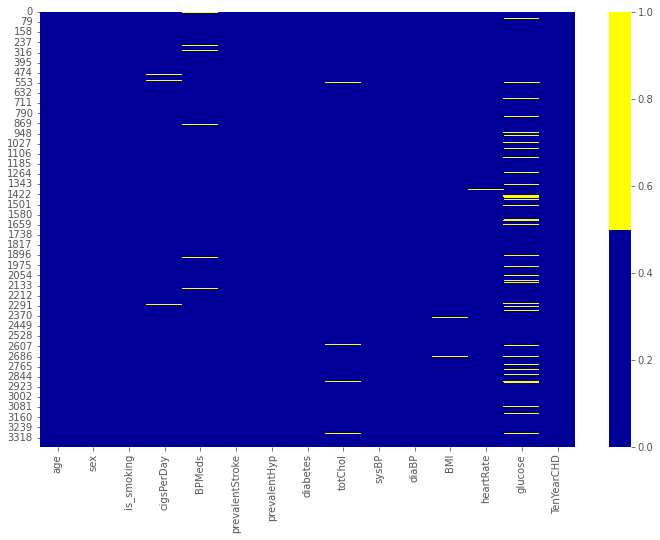

In [6]:
cols = df.columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

### Lista de porcentajes de valores faltantes por columna

In [7]:
# if it's a larger dataset and the visualization takes too long can do this.
# % of missing.
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, pct_missing*100))

age - 0.0%
sex - 0.0%
is_smoking - 0.0%
cigsPerDay - 0.6489675516224189%
BPMeds - 1.2979351032448379%
prevalentStroke - 0.0%
prevalentHyp - 0.0%
diabetes - 0.0%
totChol - 1.12094395280236%
sysBP - 0.0%
diaBP - 0.0%
BMI - 0.41297935103244837%
heartRate - 0.029498525073746312%
glucose - 8.96755162241888%
TenYearCHD - 0.0%


### Histograma de valores faltantes por observación

created missing indicator for: cigsPerDay
created missing indicator for: BPMeds
created missing indicator for: totChol
created missing indicator for: BMI
created missing indicator for: heartRate
created missing indicator for: glucose


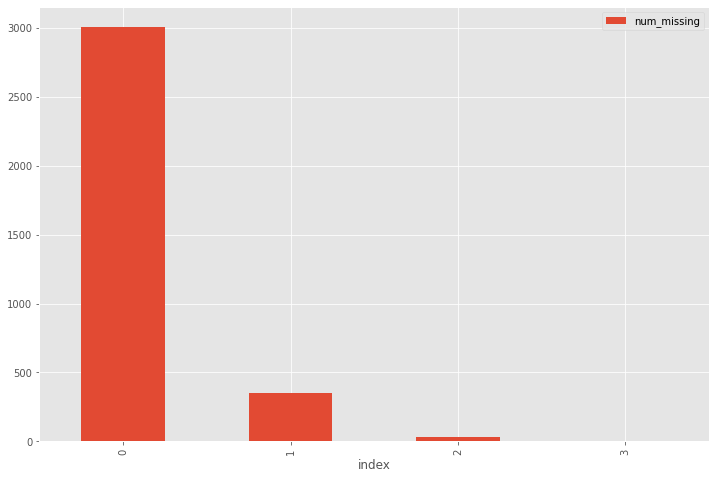

In [8]:
# first create missing indicator for features with missing data
for col in df.columns:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('created missing indicator for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing


# then based on the indicator, plot the histogram of missing values
ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)

df['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

In [9]:
df=df.drop(['cigsPerDay_ismissing','BPMeds_ismissing', 'totChol_ismissing','BMI_ismissing','heartRate_ismissing','glucose_ismissing','num_missing'], axis=1)
df.head()

,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,36,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [10]:
# impute the missing values and create the missing value indicator variables for each numeric column.
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values

for col in numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  # only do the imputation for the columns that have missing values.
        print('imputing missing values for: {}'.format(col))
        med = df[col].median()
        df[col] = df[col].fillna(med)

imputing missing values for: cigsPerDay
imputing missing values for: BPMeds
imputing missing values for: totChol
imputing missing values for: BMI
imputing missing values for: heartRate
imputing missing values for: glucose


Se rellenan los valores faltantes de cada característica utilizando la mediana de cada característica

In [11]:
# if it's a larger dataset and the visualization takes too long can do this.
# % of missing.
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, pct_missing*100))

age - 0.0%
sex - 0.0%
is_smoking - 0.0%
cigsPerDay - 0.0%
BPMeds - 0.0%
prevalentStroke - 0.0%
prevalentHyp - 0.0%
diabetes - 0.0%
totChol - 0.0%
sysBP - 0.0%
diaBP - 0.0%
BMI - 0.0%
heartRate - 0.0%
glucose - 0.0%
TenYearCHD - 0.0%


## Datos atípicos (outliers)

Utilización de histograma y diagramas de cajas para detectar los outliers por característica

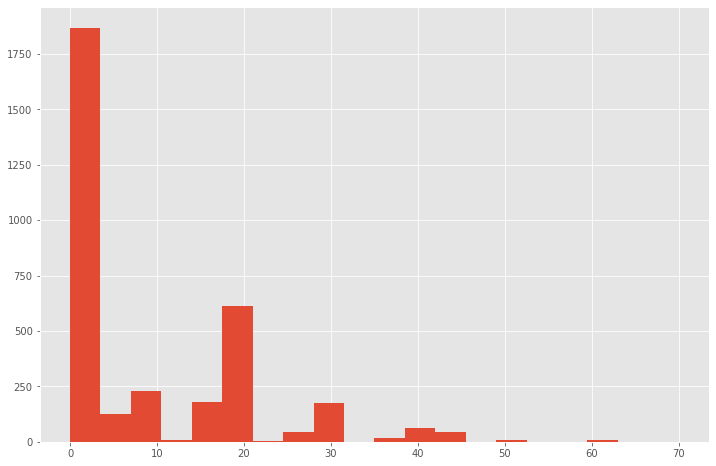

In [13]:
df['cigsPerDay'].hist(bins=20)

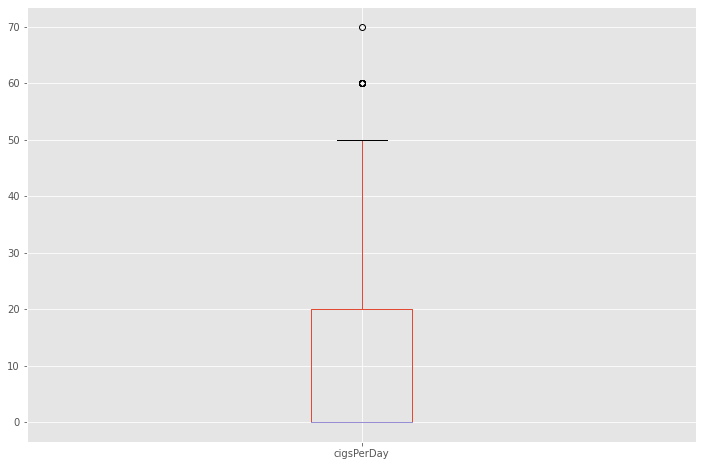

In [14]:
df.boxplot(column=['cigsPerDay'])

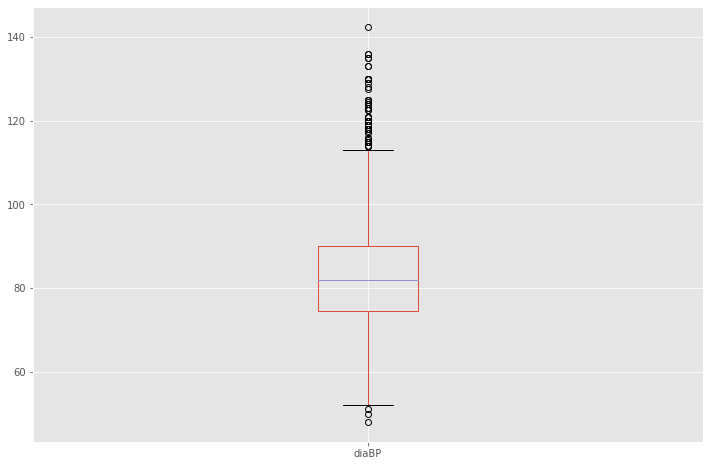

In [15]:
df.boxplot(column=['diaBP'])

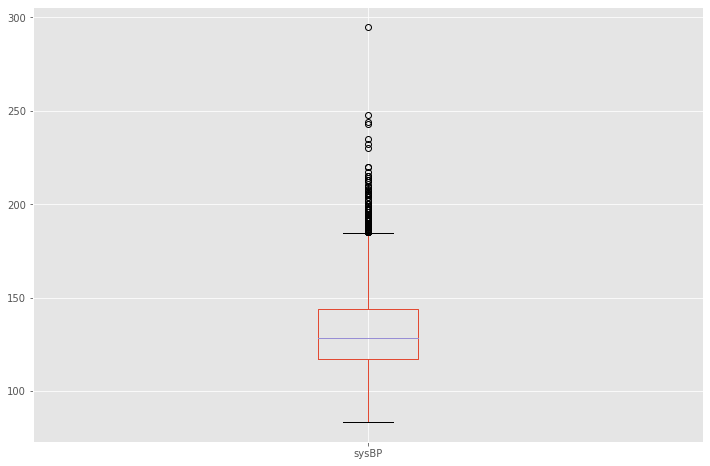

In [16]:
df.boxplot(column=['sysBP'])

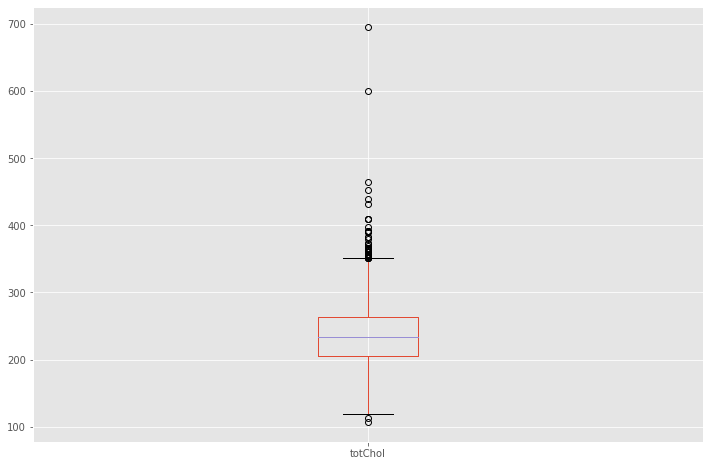

In [17]:
df.boxplot(column=['totChol'])

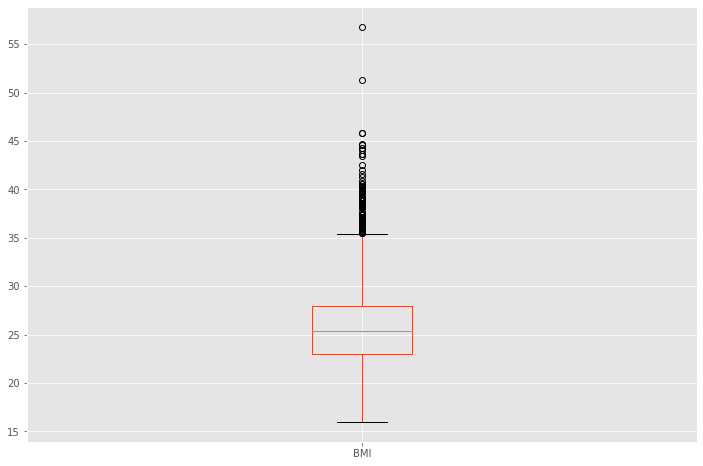

In [18]:
df.boxplot(column=['BMI'])

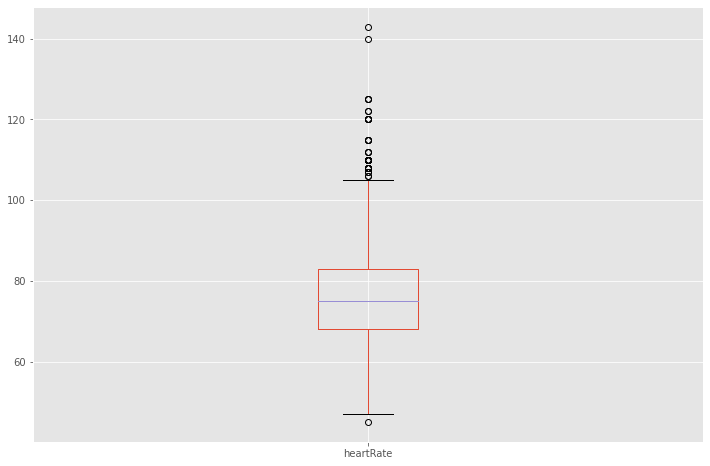

In [19]:
df.boxplot(column=['heartRate'])

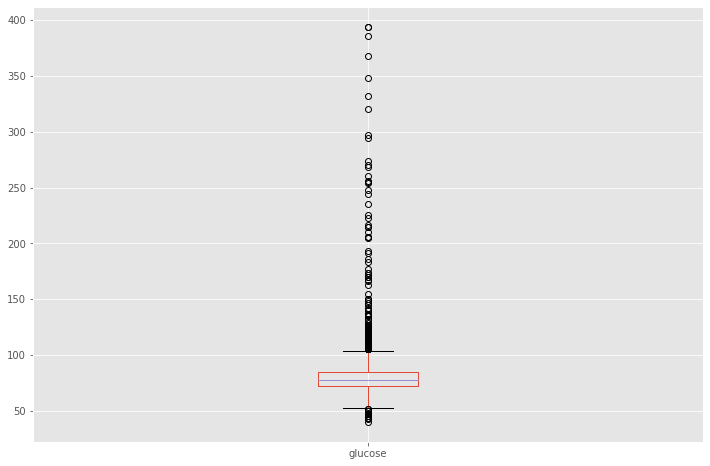

In [20]:
df.boxplot(column=['glucose'])

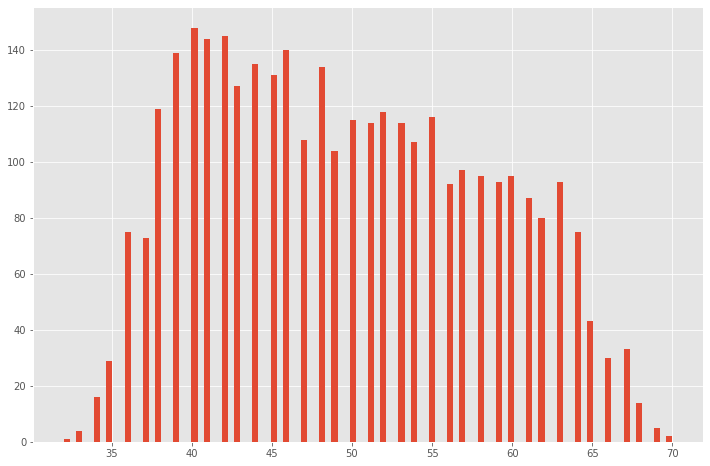

In [21]:
df['age'].hist(bins=100)

Para las variables numéricas binarias se utilizan gráficos de columnas para detectar sus valores atípicos

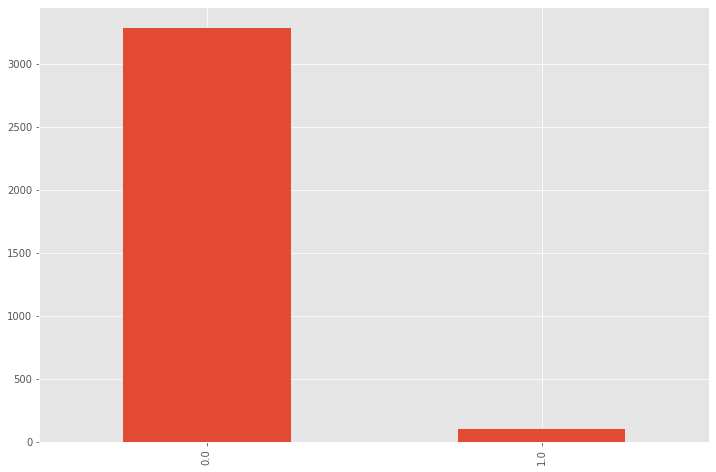

In [23]:
df['BPMeds'].value_counts().plot.bar()

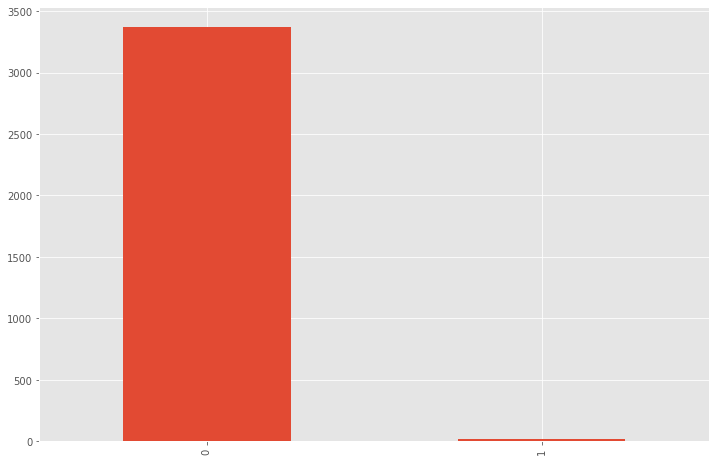

In [24]:
df['prevalentStroke'].value_counts().plot.bar()

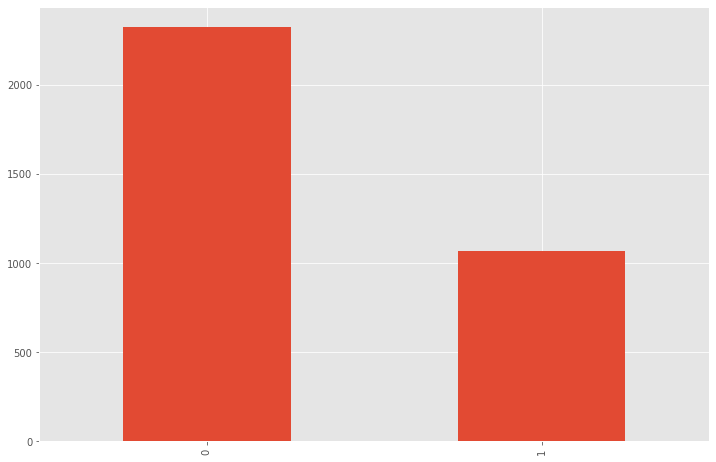

In [25]:
df['prevalentHyp'].value_counts().plot.bar()

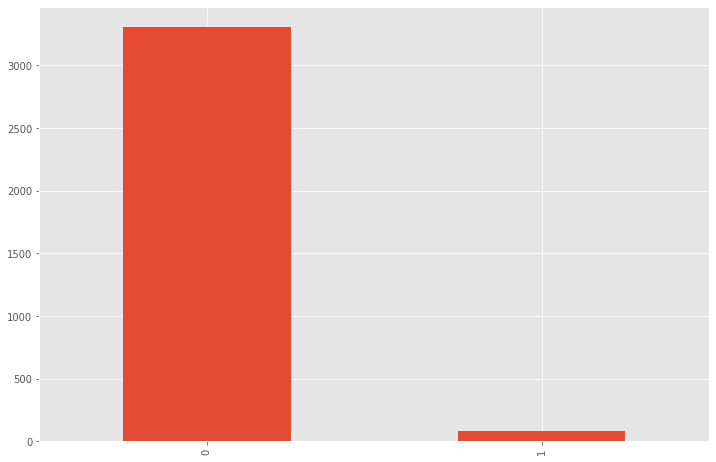

In [26]:
df['diabetes'].value_counts().plot.bar()

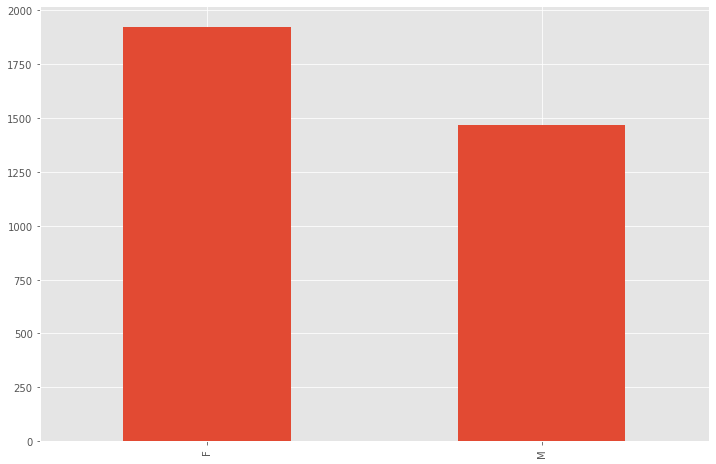

In [27]:
df['sex'].value_counts().plot.bar()

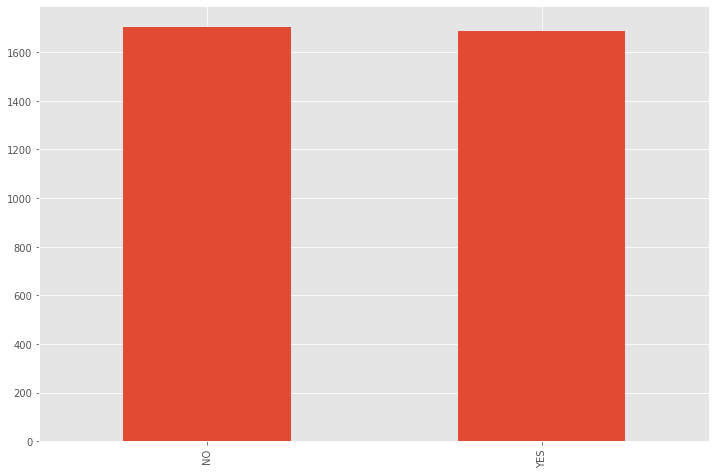

In [28]:
df['is_smoking'].value_counts().plot.bar()

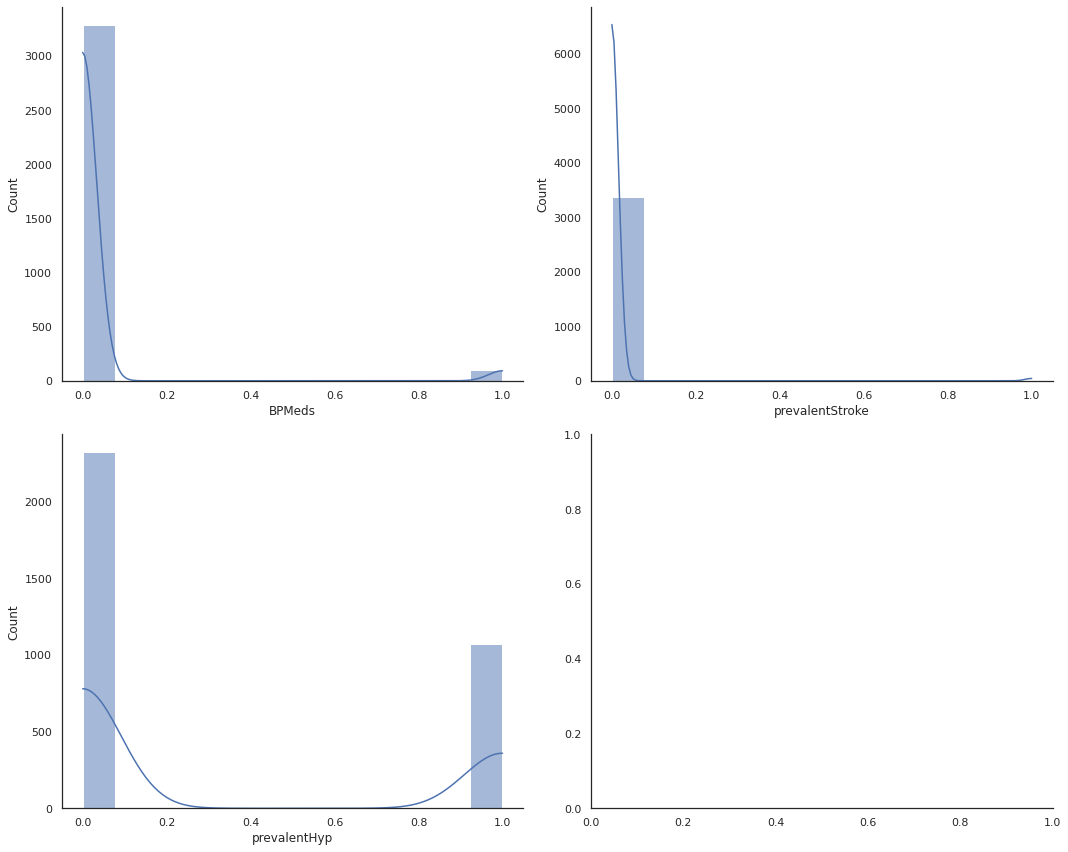

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
rows = 2
cols = 2
sns.set(font_scale = 1)
sns.set_style("white")
fig, axes = plt.subplots(figsize = [15,12],nrows=rows, ncols=cols)
for i, column in enumerate(['BPMeds','prevalentStroke','prevalentHyp']):
  sns.histplot(df[column],ax=axes[i//cols,i%cols], kde=True)
  sns.despine()
plt.tight_layout()

## Datos innecesarios

###Datos repetitivos

In [24]:
num_rows = len(df.index)
low_information_cols = [] #

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

BPMeds: 97.05015%
0.0    3290
1.0     100
Name: BPMeds, dtype: int64

prevalentStroke: 99.35103%
0    3368
1      22
Name: prevalentStroke, dtype: int64

diabetes: 97.43363%
0    3303
1      87
Name: diabetes, dtype: int64



## Transformación de variables categóricas a variables numéricas binarias

In [35]:
df['is_smoking']

0       YES
1        NO
2       YES
3       YES
4       YES
       ... 
3385     NO
3386     NO
3387    YES
3388     NO
3389     NO
Name: is_smoking, Length: 3390, dtype: object

In [25]:
df['is_smoking']=(df['is_smoking']=='YES').astype(int)

In [37]:
df['is_smoking']

0       1
1       0
2       1
3       1
4       1
       ..
3385    0
3386    0
3387    1
3388    0
3389    0
Name: is_smoking, Length: 3390, dtype: int64

In [26]:
df['sex']=(df['sex']=='M').astype(int)

##Dataset limpio

In [39]:
df.head()

,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,0,1,3.0,0.0,0,0,0,221.0,148.0,85.0,25.38,90.0,80.0,1
1,36,1,0,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,0,1,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1,1,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,0,1,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [72]:
df['TenYearCHD'].value_counts()

0    2879
1     511
Name: TenYearCHD, dtype: int64

## MODELIZACIÓN

Importación de librerías necesarias

In [27]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline

Adición de constante al dataset inicial necesaria para no eliminar el coeficiente independiente (B0).

In [28]:
from statsmodels.tools import add_constant as add_constant
heart_df_constant = add_constant(df)
heart_df_constant.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,64,0,1,3.0,0.0,0,0,0,221.0,148.0,85.0,25.38,90.0,80.0,1
1,1.0,36,1,0,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,1.0,46,0,1,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,1.0,50,1,1,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,1.0,64,0,1,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


###Ajuste del modelo con todas las variables

In [43]:
st.chisqprob = lambda chisq, df: st.chi2.sf(chisq, df)
cols=heart_df_constant.columns[:-1]
model=sm.Logit(df.TenYearCHD,heart_df_constant[cols])
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.374801
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3390
Model:                          Logit   Df Residuals:                     3375
Method:                           MLE   Df Model:                           14
Date:                Wed, 28 Sep 2022   Pseudo R-squ.:                  0.1160
Time:                        15:09:13   Log-Likelihood:                -1270.6
converged:                       True   LL-Null:                       -1437.3
Covariance Type:            nonrobust   LLR p-value:                 1.194e-62
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.3604      0.717    -11.663      0.000      -9.765      -6.955
age                 0.0628      0.007      9.075      0.000       0.049       0.076
sex                 0.4814      0.113      4.246      0.000       0.259       0.704
is_smoking          0.1362      0.160      0.852      0.394      -0.177       0.450
cigsPerDay          0.0214      0.006      3.396      0.001       0.009       0.034
BPMeds              0.1836      0.249      0.736      0.462      -0.305       0.672
prevalentStroke     1.1795      0.472      2.498      0.012       0.254       2.105
prevalentHyp        0.1880      0.145      1.299      0.194      -0.096       0.472
diabetes            0.0509      0.334      0.152      0.879      -0.604       0.705
totChol             0.0026      0.001      2.295      0.022       0.000       0.005
sysBP               0.0159      0.004      4.034      0.000       0.008       0.024
diaBP              -0.0067      0.007     -1.017      0.309      -0.020       0.006
BMI                 0.0012      0.013      0.088      0.930      -0.025       0.027
heartRate          -0.0027      0.004     -0.612      0.540      -0.011       0.006
glucose             0.0087      0.002      3.609      0.000       0.004       0.013
===================================================================================
"""

In [44]:
np.exp(result.params)

const              0.000234
age                1.064788
sex                1.618377
is_smoking         1.145952
cigsPerDay         1.021652
BPMeds             1.201536
prevalentStroke    3.252832
prevalentHyp       1.206812
diabetes           1.052210
totChol            1.002588
sysBP              1.016026
diaBP              0.993361
BMI                1.001157
heartRate          0.997337
glucose            1.008787
dtype: float64

In [46]:
np.exp(result.conf_int())

,0,1
const,0.000057,0.000953
age,1.050449,1.079322
sex,1.295882,2.021128
is_smoking,0.837708,1.567619
cigsPerDay,1.009098,1.034362
BPMeds,0.737048,1.958742
prevalentStroke,1.289328,8.206533
prevalentHyp,0.908696,1.602731
diabetes,0.546811,2.024730
totChol,1.000378,1.004804


In [47]:
params = np.exp(result.params)
conf = np.exp(result.conf_int())
conf['OR'] = params
pvalue=round(result.pvalues,3)
conf['pvalue']=pvalue
conf.columns = ['CI 95%(2.5%)', 'CI 95%(97.5%)', 'Odds Ratio','pvalue']
print ((conf))

                 CI 95%(2.5%)  CI 95%(97.5%)  Odds Ratio  pvalue
const                0.000057       0.000953    0.000234   0.000
age                  1.050449       1.079322    1.064788   0.000
sex                  1.295882       2.021128    1.618377   0.000
is_smoking           0.837708       1.567619    1.145952   0.394
cigsPerDay           1.009098       1.034362    1.021652   0.001
BPMeds               0.737048       1.958742    1.201536   0.462
prevalentStroke      1.289328       8.206533    3.252832   0.012
prevalentHyp         0.908696       1.602731    1.206812   0.194
diabetes             0.546811       2.024730    1.052210   0.879
totChol              1.000378       1.004804    1.002588   0.022
sysBP                1.008207       1.023906    1.016026   0.000
diaBP                0.980686       1.006199    0.993361   0.309
BMI                  0.975618       1.027365    1.001157   0.930
heartRate            0.988863       1.005884    0.997337   0.540
glucose              1.00

In [48]:
import sklearn
from sklearn.model_selection import train_test_split
new_features=df[['age','sex','is_smoking','prevalentHyp','prevalentStroke','diabetes','BPMeds','diaBP','BMI','heartRate','cigsPerDay','totChol','sysBP','glucose','TenYearCHD']]
x=new_features.iloc[:,:-1]
y=new_features.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=5)

In [49]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
logreg.fit(x_train,y_train)
y_pred=logreg.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [50]:
sklearn.metrics.accuracy_score(y_test,y_pred)

0.8436578171091446

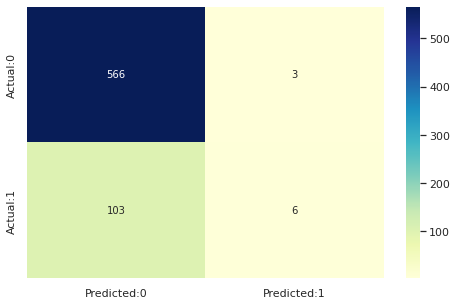

In [51]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [52]:
TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

In [53]:
print('The acuuracy of the model = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',

'The Missclassification = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',

'Sensitivity or True Positive Rate = TP/(TP+FN) = ',TP/float(TP+FN),'\n',

'Specificity or True Negative Rate = TN/(TN+FP) = ',TN/float(TN+FP),'\n',

'Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP),'\n',

'Negative predictive Value = TN/(TN+FN) = ',TN/float(TN+FN),'\n',

'Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',sensitivity/(1-specificity),'\n',

'Negative likelihood Ratio = (1-Sensitivity)/Specificity = ',(1-sensitivity)/specificity)

The acuuracy of the model = TP+TN/(TP+TN+FP+FN) =  0.8436578171091446 
 The Missclassification = 1-Accuracy =  0.15634218289085544 
 Sensitivity or True Positive Rate = TP/(TP+FN) =  0.05504587155963303 
 Specificity or True Negative Rate = TN/(TN+FP) =  0.9947275922671354 
 Positive Predictive value = TP/(TP+FP) =  0.6666666666666666 
 Negative predictive Value = TN/(TN+FN) =  0.8460388639760837 
 Positive Likelihood Ratio = Sensitivity/(1-Specificity) =  10.44036697247714 
 Negative likelihood Ratio = (1-Sensitivity)/Specificity =  0.9499627192271534


In [54]:
y_pred_prob=logreg.predict_proba(x_test)[:,:]
y_pred_prob_df=pd.DataFrame(data=y_pred_prob, columns=['Prob of no heart disease (0)','Prob of Heart Disease (1)'])
y_pred_prob_df

,Prob of no heart disease (0),Prob of Heart Disease (1)
0,0.868876,0.131124
1,0.812035,0.187965
2,0.841675,0.158325
3,0.906511,0.093489
4,0.900326,0.099674
...,...,...
673,0.935560,0.064440
674,0.878162,0.121838
675,0.915827,0.084173
676,0.810618,0.189382


Para que se utilicen solo aquellas variables que van a ser significativas estad ısticamente dentro del modelo, se ha utilizado el enfoque de eliminación hacia atrás (“backward elimination approach”). Este se ha utilizado para eliminar los atributos con el valor P más alto de uno en uno, seguido de la ejecución de la regresión repetidamente hasta que todos los atributos tengan p-valores inferiores al nivel de significación, que es 0,05.

In [73]:
def back_feature_elem (data_frame,dep_var,col_list):

    while len(col_list)>0 :
        model=sm.Logit(dep_var,data_frame[col_list])
        result=model.fit(disp=0)
        largest_pvalue=round(result.pvalues,3).nlargest(1)
        if largest_pvalue[0]<(0.05):
            return result
            break
        else:
            col_list=col_list.drop(largest_pvalue.index)

cols=heart_df_constant.columns[:-1]
result=back_feature_elem(heart_df_constant,df.TenYearCHD,cols)

In [74]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3390
Model:                          Logit   Df Residuals:                     3382
Method:                           MLE   Df Model:                            7
Date:                Wed, 28 Sep 2022   Pseudo R-squ.:                  0.1145
Time:                        15:18:07   Log-Likelihood:                -1272.7
converged:                       True   LL-Null:                       -1437.3
Covariance Type:            nonrobust   LLR p-value:                 3.478e-67
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -9.0521      0.493    -18.367      0.000     -10.018      -8.086
age                 0.0644      0.007      9.552      0.000       0.051       0.078
sex                 0.4761      0.111      4.289      0.000       0.259       0.694
cigsPerDay          0.0250      0.004      5.737      0.000       0.016       0.034
prevalentStroke     1.2384      0.466      2.656      0.008       0.324       2.152
totChol             0.0026      0.001      2.308      0.021       0.000       0.005
sysBP               0.0157      0.002      7.022      0.000       0.011       0.020
glucose             0.0089      0.002      4.895      0.000       0.005       0.013
===================================================================================
"""

In [75]:
params = np.exp(result.params)
conf = np.exp(result.conf_int())
conf['OR'] = params
pvalue=round(result.pvalues,3)
conf['pvalue']=pvalue
conf.columns = ['CI 95%(2.5%)', 'CI 95%(97.5%)', 'Odds Ratio','pvalue']
print ((conf))

                 CI 95%(2.5%)  CI 95%(97.5%)  Odds Ratio  pvalue
const                0.000045       0.000308    0.000117   0.000
age                  1.052505       1.080685    1.066502   0.000
sex                  1.295084       2.001118    1.609850   0.000
cigsPerDay           1.016599       1.034116    1.025320   0.000
prevalentStroke      1.383136       8.605056    3.449922   0.008
totChol              1.000391       1.004806    1.002596   0.021
sysBP                1.011390       1.020299    1.015835   0.000
glucose              1.005378       1.012607    1.008986   0.000


###Ajuste del modelo más parsimonioso

In [96]:
import sklearn
from sklearn.model_selection import train_test_split
new_features=df[['age','sex','cigsPerDay','prevalentStroke','totChol','sysBP','glucose','TenYearCHD']]
x=new_features.iloc[:,:-1]
y=new_features.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.25,random_state=12345)

In [97]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
logreg.fit(x_train,y_train)
y_pred=logreg.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [98]:
sklearn.metrics.accuracy_score(y_test,y_pred)

0.8596698113207547

####Métrica de evaluación del modelo

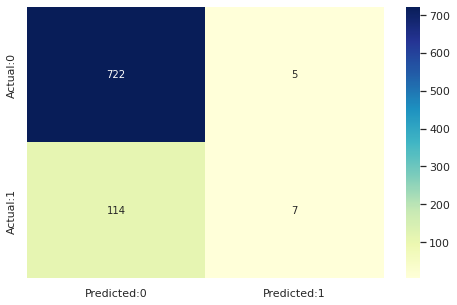

In [99]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [90]:
TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

In [109]:
Precision=TP/float(TP+FP)
Sensibilidad=TP/float(TP+FN)

print('Exactitud del modelo = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',

'No Exactitud = 1-Exactitud = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',

'Precisón = TP/(TP+FP) = ',TP/float(TP+FP),'\n',

'Sensibilidad = TP/(TP+FN) = ',TP/float(TP+FN),'\n',

'Especifidad = TN/(TN+FP) = ',TN/float(TN+FP),'\n',

'Valor predictivo positivo = TP/(TP+FP) = ',TP/float(TP+FP),'\n',

'Valor predictivo negativo = TN/(TN+FN) = ',TN/float(TN+FN),'\n',

'Puntaje F1 (F1 Score) = 2*Precision*Sensibilidad/Precision+Sensibilidad = ', 
(2*Precision*Sensibilidad)/(Precision+Sensibilidad))

Exactitud del modelo = TP+TN/(TP+TN+FP+FN) =  0.8596698113207547 
 No Exactitud = 1-Exactitud =  0.1403301886792453 
 Precisón = TP/(TP+FP) =  0.5833333333333334 
 Sensibilidad = TP/(TP+FN) =  0.05785123966942149 
 Especifidad = TN/(TN+FP) =  0.9931224209078404 
 Valor predictivo positivo = TP/(TP+FP) =  0.5833333333333334 
 Valor predictivo negativo = TN/(TN+FN) =  0.8636363636363636 
 Puntaje F1 (F1 Score) = 2*Precision*Sensibilidad/Precision+Sensibilidad =  0.10526315789473684


In [92]:
y_pred_prob=logreg.predict_proba(x_test)[:,:]
y_pred_prob_df=pd.DataFrame(data=y_pred_prob, columns=['Prob of no heart disease (0)','Prob of Heart Disease (1)'])
y_pred_prob_df

,Prob of no heart disease (0),Prob of Heart Disease (1)
0,0.762062,0.237938
1,0.813525,0.186475
2,0.831055,0.168945
3,0.542980,0.457020
4,0.928304,0.071696
...,...,...
843,0.944521,0.055479
844,0.812425,0.187575
845,0.835850,0.164150
846,0.862866,0.137134
